In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline 
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
sales = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
cal = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/calendar.csv')

In [3]:
#take the dataframe and only present the relevant category
def filter_aggregate_sales(frame, column_to_filter, column_value_to_filter, column_to_aggregate):
    frame = frame[frame[column_to_filter] == column_value_to_filter]
    frame = frame.groupby(column_to_aggregate).sum()
    return frame

In [52]:
#sum items for each day 
def total_sales(frame, column_to_sum):
    newframe = pd.DataFrame()
    newframe[column_to_sum] = frame.sum()
    newframe2 = newframe.reset_index()
    newframe3 = newframe2.rename(columns={'index':'d'})
    return newframe3

In [5]:
#merge sales with calendar 
def merge_pd(frame1, frame2, merge_index):
    newframe = pd.merge(frame1, frame2, on = merge_index, how = 'inner')
    newframe.date = pd.to_datetime(newframe.date)
    return newframe

In [6]:
#Encode column values to binary 
def events_encode(frame, column_to_encode):
    newframe = frame.copy()
    newframe[column_to_encode] = frame[column_to_encode].fillna(0)
    for i in range(len(frame)):
        if type(frame[column_to_encode][i])==str:
            newframe[column_to_encode][i] = 1
    return newframe    

In [7]:
#Add week of year feature 
def week_of_year(frame):
    newframe = pd.DataFrame()
    newframe['week_of_year'] = np.arange(len(frame))
    newframe.week_of_year= frame.date.dt.isocalendar().week
    newframe2 = frame.copy()
    newframe2['week_of_year'] = newframe
    return newframe2

In [8]:
#ETSmodel prediction feature
def ETS_predict(frame, column_to_predict, days_to_predict):
    modelETS = ETSModel(frame.set_index('date')[column_to_predict].iloc[:-days_to_predict]/100, error="add", trend="add", seasonal="add",
                damped_trend=False, seasonal_periods=7)
    fit = modelETS.fit()
    x = fit.predict(start= frame.date.min(), end= frame.date.max())
    frame = frame.assign(ETS=x.values*100).set_index('date')
    return frame

In [9]:
#Create training/test dataset
def train_test_set(frame, item, start, end):
    newframe = frame[start:end]
    input_train = newframe.drop(item, axis='columns')
    target_train = newframe[item]
    return input_train, target_train 

In [10]:
#Model and predict data using Random Forest 
def forest(X_train, y_train, X_test):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return y_predicted 

In [ ]:
#Function to combine filter_aggregate and total_sales to form day vs sales dataframe
def sort_sales(frame, column_to_filter, column_value_to_filter, column_to_aggregate):
    
    newframe = filter_aggregate_sales(frame=frame, column_to_filter=column_to_filter,
                           column_value_to_filter=column_value_to_filter, 
                           column_to_aggregate=column_to_aggregate)
    
    newframe2 = total_sales(frame=newframe, column_to_sum=column_value_to_filter)
    
    return newframe2

In [56]:
#Function to merge sales and cal AND then create the necessary features (prior to model building)
def merge_feature_eng(frame1, frame2, merge_index, column_to_encode, column_to_ETS_predict, days_to_ETS_predict):

    newframe = merge_pd(frame1=frame1, frame2=frame2, merge_index=merge_index)
    
    newframe2 = events_encode(frame=newframe, column_to_encode=column_to_encode)
    
    newframe3 = week_of_year(frame=newframe2)
    
    newframe4 = ETS_predict(newframe3, column_to_predict=column_to_ETS_predict, 
                            days_to_predict=days_to_ETS_predict)
    
    return newframe4

In [ ]:
#Function to create train/test split and do model and prediction

In [55]:
salesframe = sort_sales(frame = sales, column_to_filter = 'dept_id', column_value_to_filter= 'FOODS_3',
                        column_to_aggregate='item_id')
salesframe.head()

,d,FOODS_3
0,d_1,16741
1,d_2,16333
2,d_3,12343
3,d_4,13764
4,d_5,10525


In [58]:
mergedframe = merge_feature_eng(frame1=salesframe, frame2=cal, merge_index='d',
                                column_to_encode='event_type_1', column_to_ETS_predict='FOODS_3', 
                                days_to_ETS_predict=120)
mergedframe.head()

<ipython-input-6-133c53edbbee>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newframe[column_to_encode][i] = 1
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,d,FOODS_3,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week_of_year,ETS
date,,,,,,,,,,,,,,,,
2011-01-29,d_1,16741,11101,Saturday,1,1,2011,NaN,0,NaN,NaN,0,0,0,4,14360.207831
2011-01-30,d_2,16333,11101,Sunday,2,1,2011,NaN,0,NaN,NaN,0,0,0,4,15197.741548
2011-01-31,d_3,12343,11101,Monday,3,1,2011,NaN,0,NaN,NaN,0,0,0,5,12000.992396
2011-02-01,d_4,13764,11101,Tuesday,4,2,2011,NaN,0,NaN,NaN,1,1,0,5,11521.478058
2011-02-02,d_5,10525,11101,Wednesday,5,2,2011,NaN,0,NaN,NaN,1,0,1,5,11963.640047


In [59]:
clean_mergedframe = mergedframe.drop(['wm_yr_wk', 'weekday', 'year', 'd', 'event_name_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis='columns')
clean_mergedframe.head()

,FOODS_3,wday,month,event_type_1,week_of_year,ETS
date,,,,,,
2011-01-29,16741,1,1,0,4,14360.207831
2011-01-30,16333,2,1,0,4,15197.741548
2011-01-31,12343,3,1,0,5,12000.992396
2011-02-01,13764,4,2,0,5,11521.478058
2011-02-02,10525,5,2,0,5,11963.640047


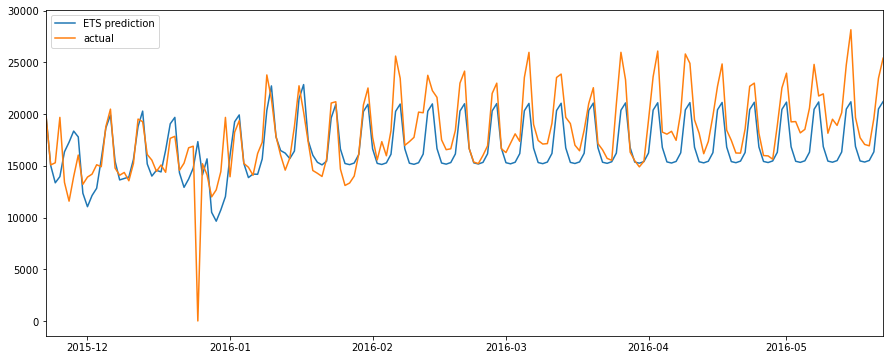

In [60]:
plt.figure(figsize=(15,6))
plt.plot(clean_mergedframe.ETS, label='ETS prediction')
plt.plot(clean_mergedframe.FOODS_3, label='actual')
plt.xlim('2015-11-22', '2016-05-22')
plt.legend()

In [11]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [12]:
df1 = filter_aggregate_sales(frame=sales, column_to_filter='dept_id', column_value_to_filter='FOODS_3',column_to_aggregate='item_id')
df1.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001,7,8,7,13,5,8,10,19,14,9,...,4,7,11,4,5,8,11,9,12,13
FOODS_3_002,0,0,0,0,0,0,0,0,0,0,...,33,41,42,41,35,19,23,23,35,26
FOODS_3_003,0,0,0,0,0,0,0,0,0,0,...,11,7,13,10,3,5,7,7,3,6
FOODS_3_004,0,0,0,0,0,0,0,0,0,0,...,3,7,2,1,3,5,4,6,6,2
FOODS_3_005,4,9,3,10,7,12,6,9,12,6,...,7,11,11,11,6,8,13,16,6,16


In [13]:
df1.shape

(823, 1941)

In [34]:
df3 = total_sales(frame=df1, column_to_sum='FOODS_3')
df3.head()

,d,FOODS_3
0,d_1,16741.0
1,d_2,16333.0
2,d_3,12343.0
3,d_4,13764.0
4,d_5,10525.0


In [35]:
df4 = merge_pd(cal, df3, 'd')
df4.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,FOODS_3
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,16741.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,16333.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,12343.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,13764.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,10525.0


In [36]:
df5 = df4.drop(['wm_yr_wk', 'weekday', 'year', 'd', 'event_name_1', 'event_name_2', 
            'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis='columns')
df5.head()

,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,NaN,16741.0
1,2011-01-30,2,1,NaN,16333.0
2,2011-01-31,3,1,NaN,12343.0
3,2011-02-01,4,2,NaN,13764.0
4,2011-02-02,5,2,NaN,10525.0


In [37]:
df5.groupby('event_type_1')['event_type_1'].agg('count')

event_type_1
Cultural     37
National     51
Religious    54
Sporting     16
Name: event_type_1, dtype: int64

In [38]:
df6 = events_encode(frame=df5, column_to_encode='event_type_1')
df6.head()

<ipython-input-6-133c53edbbee>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newframe[column_to_encode][i] = 1


,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,0,16741.0
1,2011-01-30,2,1,0,16333.0
2,2011-01-31,3,1,0,12343.0
3,2011-02-01,4,2,0,13764.0
4,2011-02-02,5,2,0,10525.0


In [39]:
df6.groupby('event_type_1')['event_type_1'].agg('count')

event_type_1
0    1783
1     158
Name: event_type_1, dtype: int64

In [40]:
df7 = week_of_year(frame=df6)
df7.head()

,date,wday,month,event_type_1,FOODS_3,week_of_year
0,2011-01-29,1,1,0,16741.0,4
1,2011-01-30,2,1,0,16333.0,4
2,2011-01-31,3,1,0,12343.0,5
3,2011-02-01,4,2,0,13764.0,5
4,2011-02-02,5,2,0,10525.0,5


In [41]:
df8 = ETS_predict(frame=df7, column_to_predict='FOODS_3', days_to_predict=120)
df8

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,wday,month,event_type_1,FOODS_3,week_of_year,ETS
date,,,,,,
2011-01-29,1,1,0,16741.0,4,14360.207831
2011-01-30,2,1,0,16333.0,4,15197.741548
2011-01-31,3,1,0,12343.0,5,12000.992396
2011-02-01,4,2,0,13764.0,5,11521.478058
2011-02-02,5,2,0,10525.0,5,11963.640047
...,...,...,...,...,...,...
2016-05-18,5,5,0,17069.0,20,15367.524582
2016-05-19,6,5,0,16935.0,20,15521.681264
2016-05-20,7,5,0,19586.0,20,16354.892664


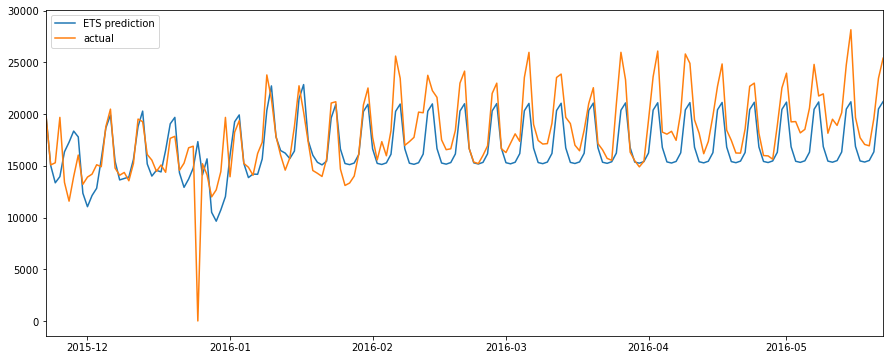

In [42]:
plt.figure(figsize=(15,6))
plt.plot(df8.ETS, label='ETS prediction')
plt.plot(df6.date, df6.FOODS_3, label='actual')
plt.xlim('2015-11-22', '2016-05-22')
plt.legend()

In [43]:
X_train,y_train = train_test_set(frame=df8, item='FOODS_3', start='2011-01-29', end='2016-01-22')

In [44]:
print(X_train.shape, y_train.shape)

(1820, 5) (1820,)


In [45]:
X_test,y_test = train_test_set(frame=df8, item='FOODS_3', start='2016-01-24', end='2016-05-22')

In [46]:
print(X_test.shape, y_test.shape)

(120, 5) (120,)


In [47]:
y_predicted = forest(X_train=X_train, y_train=y_train, X_test=X_test)
y_predicted

array([18746., 15298., 13216., 13120., 12983., 15807., 20452., 20832.,
       16699., 17443., 14416., 15784., 17630., 23231., 20427., 16699.,
       17443., 17783., 15784., 15432., 21030., 20427., 16976., 16960.,
       17783., 12155., 13180., 21364., 20824., 17484., 14496., 17288.,
       13644., 15271., 19091., 21162., 14949., 14684., 14296., 16058.,
       17492., 23136., 24470., 17986., 14684., 14296., 16058., 16815.,
       20134., 21629., 16797., 14755., 14497., 15778., 16548., 20421.,
       22768., 15240., 13566., 14684., 14634., 15216., 18567., 19970.,
       16337., 14287., 13363., 14929., 19775., 22010., 21595., 16749.,
       18114., 17171., 18357., 19775., 22010., 22843., 16261., 16590.,
       15234., 15813., 19775., 19144., 21287., 15905., 14103., 13788.,
       14806., 15979., 19144., 20464., 14418., 13613., 15354., 15758.,
       15648., 20141., 21075., 20912., 15709., 16454., 17362., 18384.,
       22637., 21075., 17347., 15709., 15041., 15086., 16545., 21658.,
      

In [48]:
print(len(y_test), len(y_predicted))

120 120


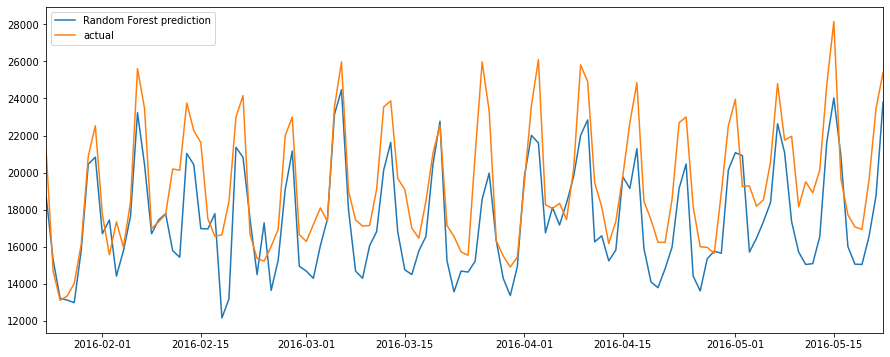

In [49]:
plt.figure(figsize=(15,6))
plt.plot(X_test.index, y_predicted, label='Random Forest prediction')
plt.plot(y_test, label='actual')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()

In [50]:
len(df8['2016-01-24':'2016-05-22'])

120

In [51]:
#Compare FOODS_3 average sales with RMSE 
print("Average sales for foods(3) items is: ", y_test.mean())
rmse = sqrt(mean_squared_error(y_test, y_predicted))
print("Root mean squared error is: ", rmse)

Average sales for foods(3) items is:  19364.208333333332
Root mean squared error is:  2547.0571891891236
